# Emotional Consistency among Political Ideologies: An Approach to Address Polarization on Youtube

Group 5:
- Chance Landis (ChancL), Hanna Lee (Lee10), Jason Sun (YongXs), Andy Wong (WongA22)

## Credit Listing
- Hanna: Democratic-leaning Channels Data Collection
- Chance: Republican-leaning Channels Data Collection
- Andy: Exploratory Data Analysis
- Jason: Text Documentation

## Problem Statement
We want to figure out whether the current political polarization is associated with the emotional values expressed by each party. Due to the current politically charged environment of our country, the semblance of sympathizing toward a value that is not related to your political party causes backlash. This fear of backlash can create a “false” polarized environment, which is an extension of the fear itself. The question that arises is whether these boundaries are reinforced by the people themselves and/or  external factors, like social media.

## Research Question
1. Do political parties exhibit similar emotional responses to differing ideologies?

## Data Collection
To investigate this topic, we will analyze content from the top five YouTube channels associated with Democratic and Republican viewpoints, based on subscriber counts. The channels selected for the study are:

- **Democratic-leaning Channels**: Vice, Vox, MSNBC, The Daily Show, The Young Turks
- **Republican-leaning Channels**: Fox News, Ben Shapiro, Steven Crowder, The Daily Mail, The Daily Wire

We have identified eight key ideologies for this analysis to understand if there are emotional differences in how political parties discuss these topics. For each ideology, a set of keywords has been established to facilitate data scraping:

- **ISIS**: ISIS, Radicalist, Islamic State, Jihadist, Syria conflict, Iraq insurgency, Al-Qaeda, Radical Islam, Suicide bombings, Mosul
- **Guns**: Gun, Shooting, School shooting, Firearm, Gun control, NRA, Second Amendment
- **Immigration**: Immigration, Border control, Mexico, Visa, Citizenship, Asylum, Deportation, Refugee
- **Economy**: Economy, Budget deficit, Unemployment rate, Inflation, Interest rate, Federal reserve, Recession, GDP, Consumer Price Index, Trade Balance, Stock Exchange, Central bank, Consumer spending, NASDAQ, Dow Jones, S&P, currency exchange, Financial crisis, Investment strategies, Credit rating, Commodities, Real estate market, Banking sector
- **Health care**: Health care, Medicaid, Covid, Obamacare, Public health, Insurance, Universal healthcare, Private healthcare, Medicare, Patient rights, Vaccination, Pandemics
- **Socio-economic**: Socio-economic, Rich, Poor, Income inequality, Poverty, Wealth distribution, Minimum Wage, Financial Insecurity, Welfare, Homelessness, Financial Literacy
- **Abortion**: Abortion, Pregnancy, Unwanted Pregnancy, Roe, Wade, Pro-life, Planned Parenthood, Fetal rights, Life of mother, Reproductive, Women's health, Gestational, Late-term abortion, Post-abortion syndrome, Safe haven laws, Mifepristone, Misoprostol, Dobbs, Pro-choice, Anti-abortion
- **Climate change**: Climate change, Global Warming, Carbon, Alternative Energy, Climate, Methane, Emissions, Gas, Greenhouse, Renewable energy, Fossil fuels, Deforestation, Carbon footprint

### Sources of Information
- **AllSides**: A media bias tool that provides a rating based on "multi-partisan Editorial Reviews by trained experts and Blind Bias Surveys™ in which participants rate content without knowing the source." We used this tool to determine how we should classify the most popular (based on subscriber count) YouTube channels we found. (Source: https://www.allsides.com/media-bias/media-bias-rating-methods)
- **HypeAuitor**: A company that uses a data-driven approach to influencer marketing. In the process, they collated lists of YouTube based on category, subscriber count, and country. This allowed us to find YouTube channels that focused on news and politics with the most subscribers. (Source: https://hypeauditor.com/about/company/, https://hypeauditor.com/top-youtube-news-politics-united-states/)
- **Pew Research Center**: A nonpartisan, nonprofit organization that conducts research on public opinion, demographic trends, and social issues. It provides data-driven insights into various aspects of social science issues, explicitly stating they do not take a stance on political issues. For our research, we relied on their studies on political ideologies and alignment with political parties as a reference. (Source: https://www.pewresearch.org/about/, https://www.pewresearch.org/politics/2016/06/22/5-views-of-parties-positions-on-issues-ideologies/)
- **YouTube**: As a group, we've chosen to expand our collection of YouTube videos by selecting additional keywords associated with the ideology we're studying. Our focus will be on gathering comments from these videos to conduct our research.
    - We used a combination of Andy and Hanna's code to get the comments from YouTube channels.

### Changes from Part 1

- After Part 1 of our analysis, we expanded our keyword pool to capture a broader range of titles spanning various ideologies, aiming for a more balanced dataset. During this process, we observed significant disparities in content related to ISIS, socio-economic, and economy ideologies. To address this discrepancy, we incorporated videos from MSNBC (representing democratic views) and Fox News (representing republican views) to supplement the content lacking in other YouTube channels. However, there remained a shortage of ISIS-related videos across both channels. As a result, the number of videos representing the ISIS (terrorism) ideology was 10-15 fewer compared to other ideologies within each political affiliation.
- We made the decision to eliminate positive and negative emotion classifications from our analysis. Positivity/Negativity is already calculated in a prior measurement, and the positivity/negativity of a comment is not indicative of emotions within the comment. The remaining 8 emotions are more aligned with what we are interested in examining, and thus we decided to take the highest value emotion that was not positive or negative. A comment that exhibits anger can be both positive or negative (though it may be skewed in one direction. This case being negative.)

In [9]:
# !pip install --upgrade google-api-python-client --quiet
# !pip install nltk --quiet
# !pip install nrclex --quiet

In [10]:
# imports
import json
import nltk

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import googleapiclient
import googleapiclient.discovery
import googleapiclient.errors
from googleapiclient.errors import HttpError

import re
import datetime
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import casual

from nrclex import NRCLex

In [14]:
# Function for Text Cleaning
def textcleaner(row):
    row = str(row)
    row = row.lower()
    # remove punctuation
    row = re.sub(r'[^\w\s]', '', row)
    #remove urls
    row  = re.sub(r'http\S+', '', row)
    #remove mentions
    row = re.sub(r"(?<![@\w])@(\w{1,25})", '', row)
    #remove hashtags
    row = re.sub(r"(?<![#\w])#(\w{1,25})", '',row)
    #remove other special characters
    row = re.sub('[^A-Za-z .-]+', '', row)
        #remove digits
    row = re.sub('\d+', '', row)
    row = row.strip(" ")
    row = re.sub('\s+', ' ', row)
    return row
    
# Function for Stopword Removal
stopeng = set(stopwords.words('english'))
def remove_stop(text):
    try:
        words = text.split(' ')
        valid = [x for x in words if x not in stopeng]
        return(' '.join(valid))
    except AttributeError:
        return('')

# Function for Checking NRC Lexicon Sentiment (Pos / Neg)
def nrc_sen(text, cat):
    sen = NRCLex(text)
    if cat == 'pos':
        return sen.affect_frequencies['positive']
    else:
        return sen.affect_frequencies['negative']
    
# Function for checking NRC Lexicon Emotion (Returns highest emotion)
def nrc_emo(text, ver):
    emo = NRCLex(text).affect_frequencies
    del emo['positive']
    del emo['negative']
    max_emo = max(emo, key=emo.get) 
    max_score = emo[max_emo]
    if ver == 'score':
        return max_score
    else:
        return max_emo

In [15]:
def data_cleaning_processing(df):
    # drop NA
    df = df.dropna()
    
    # Change date columns to a date type
    df['published_at'] = df['published_at'].apply(lambda x: datetime.strptime(str(x)[0:10], '%Y-%m-%d').date())
    df['CommentCreationTime'] = df['CommentCreationTime'].apply(lambda x: datetime.strptime(str(x)[0:10], '%Y-%m-%d').date())

    # Tokenize
    df['TitleToken'] = df['title'].apply(lambda x: casual.TweetTokenizer().tokenize(x))
    df['CommentToken'] = df['CommentTitle'].apply(lambda x: casual.TweetTokenizer().tokenize(x))
    
    # Clean text
    df['TitleCleaned'] = df['TitleToken'].apply(lambda x: remove_stop(textcleaner(x)))
    df['CommentCleaned'] = df['CommentToken'].apply(lambda x: remove_stop(textcleaner(x)))
    
    # Calculate Positivity/Negativity Scores for Titles and Comments
    df['TitlePos'] = df['TitleCleaned'].apply(lambda x: nrc_sen(x, 'pos'))
    df['TitleNeg'] = df['TitleCleaned'].apply(lambda x: nrc_sen(x, 'neg'))    
    df['CommentPos'] = df['CommentCleaned'].apply(lambda x: nrc_sen(x, 'pos'))    
    df['CommentNeg'] = df['CommentCleaned'].apply(lambda x: nrc_sen(x, 'neg'))
    
    # Calculate Emotion Scores for Titles and Comments
    df['TitleEmotion'] = df['TitleCleaned'].apply(lambda x: nrc_emo(x, 'emo'))
    df['TitleEmotionScore'] = df['TitleCleaned'].apply(lambda x: nrc_emo(x, 'score'))    
    df['CommentEmotion'] = df['CommentCleaned'].apply(lambda x: nrc_emo(x, 'emo'))
    df['CommentEmotionScore'] = df['CommentCleaned'].apply(lambda x: nrc_emo(x, 'score'))  

    return df

In [16]:
# Function to map keywords to ideologies
def map_keyword_to_ideology(keyword):
    return keyword_to_ideology.get(keyword.lower())

# Add an ideology column based on keyword to the dataset
keyword_lists = {
    "isis": ["ISIS", "Radicalist", "Islamic State", "Jihadist", "Syria conflict", "Iraq insurgency", "Al-Qaeda", "Radical Islam", "Suicide bombings", "Mosul"],
    "guns": ["Gun", "Shooting", "School shooting", "Firearm", "Gun control", "NRA", "Second Amendment"],
    "immigration": ["Immigration", "Border control", "Mexico", "Visa", "Citizenship", "Asylum", "Deportation", "Refugee"],
    "economy": ["Economy", "Budget deficit", "Unemployment rate", "Inflation", "Interest rate", "Federal reserve", "Recession", "GDP", "Consumer Price Index", "Trade Balance", "Stock Exchange", "Central bank", "Consumer spending", "NASDAQ", "Dow Jones", "S&P", "currency exchange", "Financial crisis", "Investment strategies", "Credit rating", "Commodities", "Real estate market", "Banking sector"],
    "healthcare": ["Health care", "Medicaid", "Covid", "Obamacare", "Public health", "Insurance", "Universal healthcare", "Private healthcare", "Medicare", "Patient rights", "Vaccination", "Pandemics"],
    "socioeco": ["Socio-economic", "Rich", "Poor", "Income inequality", "Poverty", "Wealth distribution", "Minimum Wage", "Financial Insecurity", "Welfare", "Homelessness", "Financial Literacy"],
    "abortion": ["Abortion", "Pregnancy", "Unwanted Pregnancy", "Roe", "Wade", "Pro-life", "Planned Parenthood", "Fetal rights", "Life of mother", "Reproductive", "Women's health", "Gestational", "Late-term abortion", "Post-abortion syndrome", "Safe haven laws", "Mifepristone", "Misoprostol", "Dobbs", "Pro-choice", "Anti-abortion"],
    "climate": ["Climate change", "Global Warming", "Carbon", "Alternative Energy", "Climate", "Methane", "Emissions", "Gas", "Greenhouse", "Renewable energy", "Fossil fuels", "Deforestation", "Carbon footprint"]
}

keyword_to_ideology = {}
for ideology, keywords in keyword_lists.items():
    for keyword in keywords:
        keyword_to_ideology[keyword.lower()] = ideology

def add_ideology_col(df):
    # Applying the mapping function to the 'keyword' column to create a new 'ideology' column
    df['ideology'] = df['keyword'].apply(map_keyword_to_ideology)
    return df

# Democratic Data

In [3]:
demo_df = pd.read_csv("democrat_comments.csv")

In [17]:
demo_df = data_cleaning_processing(demo_df)

In [18]:
demo_df = add_ideology_col(demo_df)

In [19]:
demo_df.head(10)

,channel,id,title,keyword,published_at,VideoViews,VideoId,CommentId,CommentTitle,CommentCreationTime,...,CommentCleaned,TitlePos,TitleNeg,CommentPos,CommentNeg,TitleEmotion,TitleEmotionScore,CommentEmotion,CommentEmotionScore,ideology
0,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgyT8lzHq4KG18pbEAx4AaABAg,A lot of businesses are struggling. The ones t...,2020-09-23,...,lot businesses struggling ones struggling much...,0.0,0.333333,0.000000,0.000000,fear,0.333333,fear,0.000000,healthcare
1,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgwWciuwhjWJtn5p2B54AaABAg,Damn the World really sucks now.\nLooking forw...,2020-09-23,...,damn world really sucks looking forward better...,0.0,0.333333,0.250000,0.250000,fear,0.333333,anger,0.250000,healthcare
2,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgxAbD9h5oBPSxaRgvN4AaABAg,"Sadly I think at least 50% of clubs, bars and ...",2020-09-24,...,sadly think least clubs bars restaurants world...,0.0,0.333333,0.333333,0.333333,fear,0.333333,sadness,0.333333,healthcare
3,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,Ugx5ivt655zG1cctmVJ4AaABAg,I love Plant. It was one of the highlights to ...,2020-09-27,...,love plant one highlights trip korea sad see m...,0.0,0.333333,0.250000,0.250000,fear,0.333333,surprise,0.250000,healthcare
4,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgztX1erPMN0W9t8tWZ4AaABAg,"""AKA DJ Bowlcut"" lmao 😂😅😅",2020-09-23,...,aka dj bowlcut lmao,0.0,0.333333,0.000000,0.000000,fear,0.333333,fear,0.000000,healthcare
5,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgzNva2CkdiLdgwcf2V4AaABAg,"I was in Soputh Korea recently. Beautiful, pe...",2020-09-23,...,soputh korea recently beautiful peaceful amazi...,0.0,0.333333,0.285714,0.000000,fear,0.333333,joy,0.285714,healthcare
6,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgwRLgppH0gj3WEB7Pl4AaABAg,I was in South Korea last year! Really enjoyed...,2020-09-24,...,south korea last year really enjoyed loved par...,0.0,0.333333,0.000000,0.000000,fear,0.333333,fear,0.000000,healthcare
7,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,Ugy_2Vxo48zxC8oU6q14AaABAg,Damn that place was the spot to party people w...,2020-09-23,...,damn place spot party people would come hit ba...,0.0,0.333333,0.000000,0.400000,fear,0.333333,anger,0.400000,healthcare
8,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgxqXQ3YALM74Tch2gp4AaABAg,For those asking 'why only Korean nightclubs' ...,2020-09-24,...,asking korean nightclubs video originally aire...,0.0,0.333333,0.214286,0.285714,fear,0.333333,fear,0.142857,healthcare
9,Vice,qX_aaRepdIM,Running a Nightclub During a Pandemic,Pandemics,2020-09-23,137070,qX_aaRepdIM,UgyXco0zyRLf8Q7ibVN4AaABAg,"Damn. I was in Seoul last year, hope the world...",2020-09-23,...,damn seoul last year hope world recovers quickly,0.0,0.333333,0.125000,0.125000,fear,0.333333,anger,0.125000,healthcare


In [11]:
# Basic DF Properties
print('DF Dimensions: ' + str(demo_df.shape))
for row in demo_df:
    print('%s: ' %row + str(type(demo_df[row][0])))

DF Dimensions: (11662, 24)
channel: <class 'str'>
id: <class 'str'>
title: <class 'str'>
keyword: <class 'str'>
published_at: <class 'datetime.date'>
VideoViews: <class 'numpy.int64'>
VideoId: <class 'str'>
CommentId: <class 'str'>
CommentTitle: <class 'str'>
CommentCreationTime: <class 'datetime.date'>
CommentLikes: <class 'numpy.int64'>
TitleToken: <class 'list'>
CommentToken: <class 'list'>
TitleCleaned: <class 'str'>
CommentCleaned: <class 'str'>
TitlePos: <class 'numpy.float64'>
TitleNeg: <class 'numpy.float64'>
CommentPos: <class 'numpy.float64'>
CommentNeg: <class 'numpy.float64'>
TitleEmotion: <class 'str'>
TitleEmotionScore: <class 'numpy.float64'>
CommentEmotion: <class 'str'>
CommentEmotionScore: <class 'numpy.float64'>
ideology: <class 'str'>


# Democratic Visualization

Percentage Title Emotion Distribution
fear: 0.599010
trust: 0.235149
disgust: 0.012376
anger: 0.049505
sadness: 0.042079
anticipation: 0.032178
joy: 0.009901
surprise: 0.019802


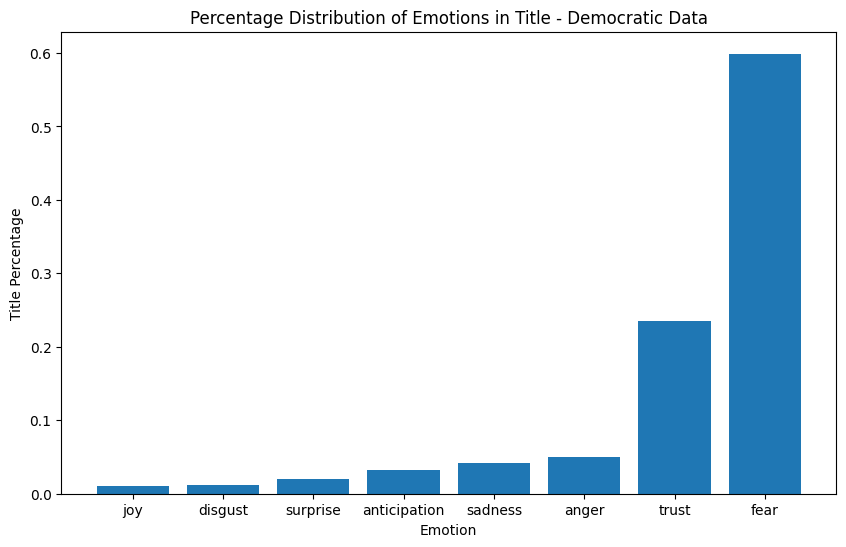

In [12]:
# Drop Duplicate Title Points
demo_df_title = demo_df.drop_duplicates(subset=['title'])

# Comment Emotion Distribution Analysis
print('Percentage Title Emotion Distribution')
emo_per = {}

# Calculate and Output Emotion Percentage
for emo in demo_df_title['TitleEmotion'].unique():
    emo_per[emo] = len(demo_df_title[demo_df_title['TitleEmotion'] == emo])/len(demo_df_title)
    print('%s: %f' %(emo, emo_per[emo]))

# Order and Plot values
emo_per = dict(sorted(emo_per.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_per.keys(), emo_per.values())
plt.xlabel('Emotion')
plt.ylabel('Title Percentage')
plt.title('Percentage Distribution of Emotions in Title - Democratic Data');

Percentage Comment Emotion Distribution
fear: 0.455582
anger: 0.072372
sadness: 0.046304
surprise: 0.031898
joy: 0.049991
anticipation: 0.063883
disgust: 0.013548
trust: 0.266421


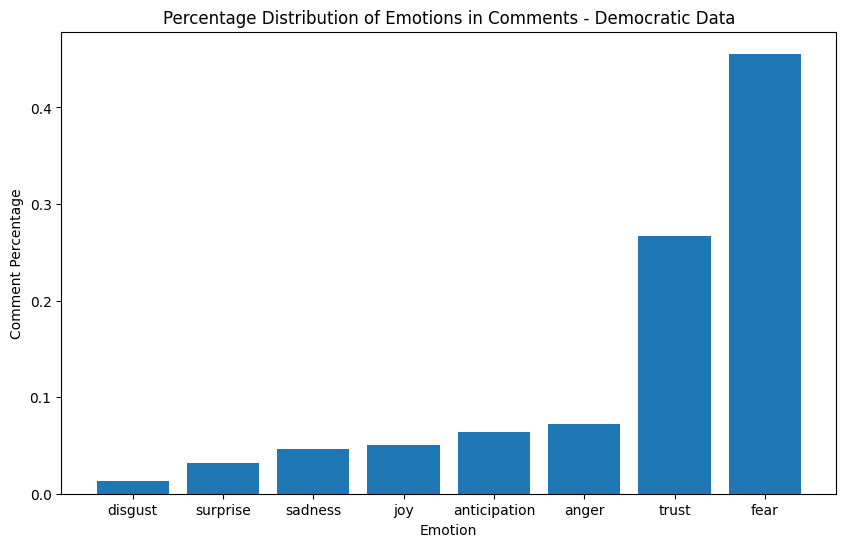

In [13]:
# Comment Emotion Distribution Analysis
print('Percentage Comment Emotion Distribution')
emo_per = {}

# Calculate and Output Emotion Percentage
for emo in demo_df['CommentEmotion'].unique():
    emo_per[emo] = len(demo_df[demo_df['CommentEmotion'] == emo])/len(demo_df)
    print('%s: %f' %(emo, emo_per[emo]))

# Order and Plot values
emo_per = dict(sorted(emo_per.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_per.keys(), emo_per.values())
plt.xlabel('Emotion')
plt.ylabel('Comment Percentage')
plt.title('Percentage Distribution of Emotions in Comments - Democratic Data');

Average Score per Emotion
fear: 0.224970
trust: 0.445923
disgust: 0.346667
anger: 0.317465
sadness: 0.445149
anticipation: 0.517560
joy: 0.399306
surprise: 0.436111


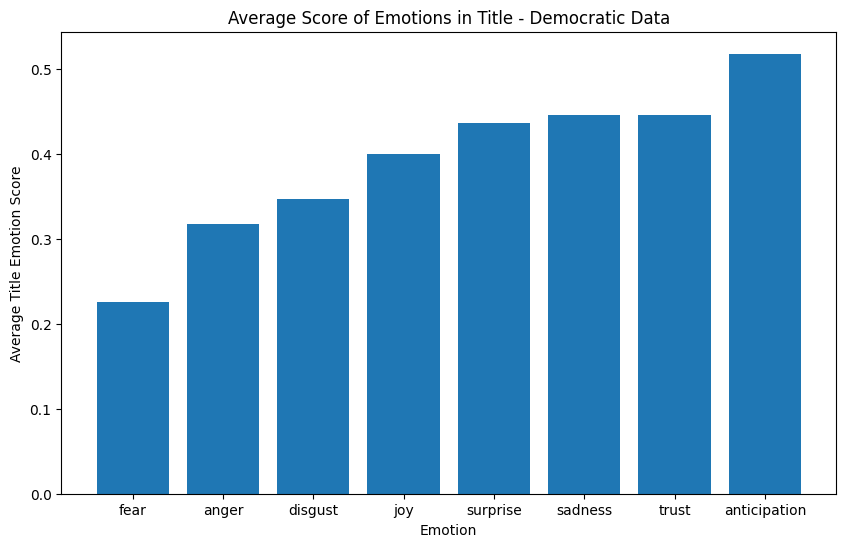

In [14]:
# Average Score per Emotion - Title

# Comment Emotion Distribution Analysis
print('Average Score per Emotion')
emo_score = {}

# Calculate and Output Emotion Percentage
for emo in demo_df_title['TitleEmotion'].unique():
    emo_score[emo] = demo_df_title[demo_df_title['TitleEmotion'] == emo]['TitleEmotionScore'].mean()
    print('%s: %f' %(emo, emo_score[emo]))

# Order and Plot values
emo_score = dict(sorted(emo_score.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_score.keys(), emo_score.values())
plt.xlabel('Emotion')
plt.ylabel('Average Title Emotion Score')
plt.title('Average Score of Emotions in Title - Democratic Data');


Average Score per Emotion
fear: 0.127831
anger: 0.237685
sadness: 0.301079
surprise: 0.427699
joy: 0.325878
anticipation: 0.465037
disgust: 0.352419
trust: 0.321944


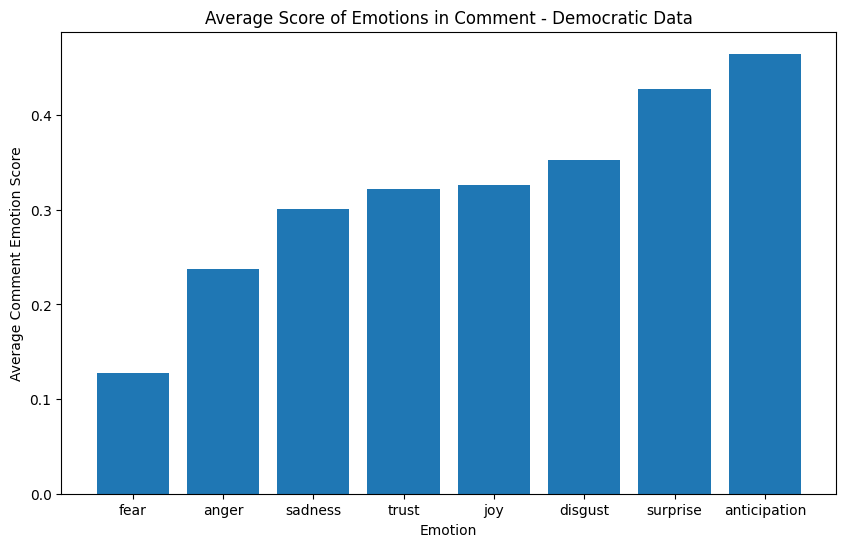

In [15]:
# Average Score per Emotion - Comment

# Comment Emotion Distribution Analysis
print('Average Score per Emotion')
emo_score = {}

# Calculate and Output Emotion Percentage
for emo in demo_df['CommentEmotion'].unique():
    emo_score[emo] = demo_df[demo_df['CommentEmotion'] == emo]['CommentEmotionScore'].mean()
    print('%s: %f' %(emo, emo_score[emo]))

# Order and Plot values
emo_score = dict(sorted(emo_score.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_score.keys(), emo_score.values())
plt.xlabel('Emotion')
plt.ylabel('Average Comment Emotion Score')
plt.title('Average Score of Emotions in Comment - Democratic Data');


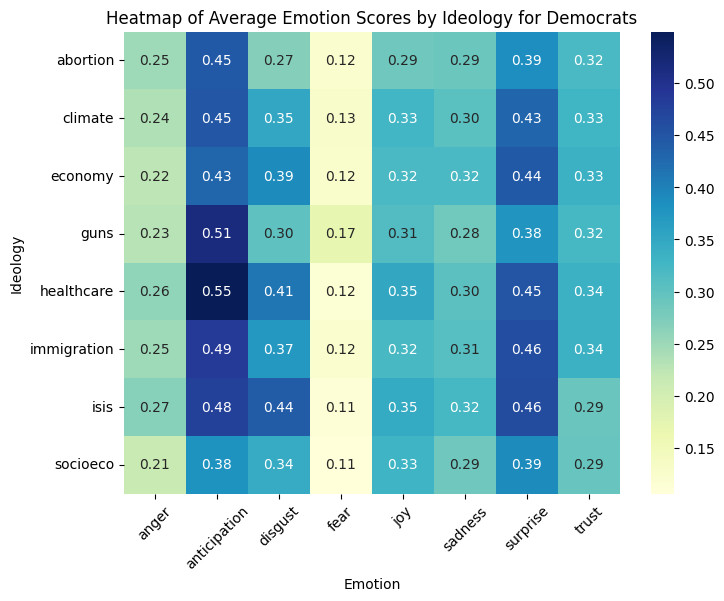

In [16]:
# Grouping the data by 'ideology' and then by 'Emotion' for the Democrats
demo_df_by_ideology = demo_df.groupby(['ideology', 'CommentEmotion'])['CommentEmotionScore'].mean().unstack(fill_value=0)

# Using seaborn to create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(demo_df_by_ideology, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Average Emotion Scores by Ideology for Democrats')
plt.xlabel('Emotion')
plt.ylabel('Ideology')
plt.xticks(rotation=45)
plt.show()

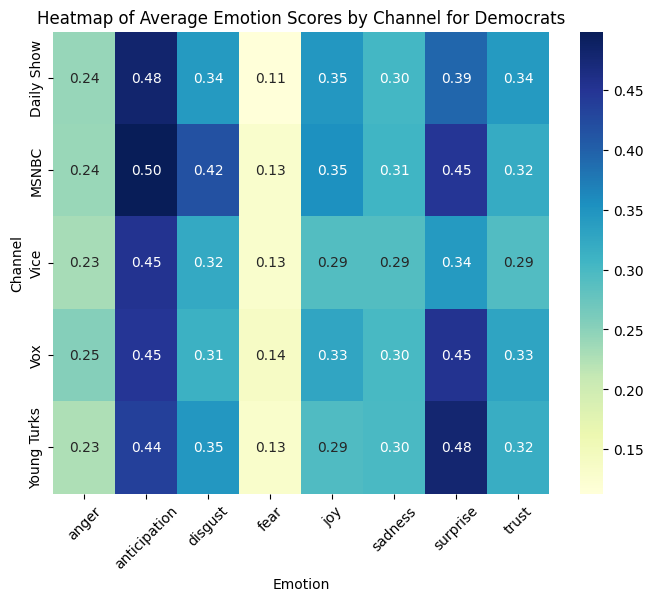

In [17]:
# Grouping the data by 'ideology' and then by 'Emotion' for the Democrats
demo_df_by_channel = demo_df.groupby(['channel', 'CommentEmotion'])['CommentEmotionScore'].mean().unstack(fill_value=0)

# Using seaborn to create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(demo_df_by_channel, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Average Emotion Scores by Channel for Democrats')
plt.xlabel('Emotion')
plt.ylabel('Channel')
plt.xticks(rotation=45)
plt.show()

# Republican Data

In [18]:
republican_df = pd.read_csv("republican_comments.csv")

In [19]:
republican_df = data_cleaning_processing(republican_df)

In [20]:
republican_df = add_ideology_col(republican_df)

In [21]:
# Basic DF Properties
print('DF Dimensions: ' + str(demo_df.shape))
for row in demo_df:
    print('%s: ' %row + str(type(demo_df[row][0])))

DF Dimensions: (11662, 24)
channel: <class 'str'>
id: <class 'str'>
title: <class 'str'>
keyword: <class 'str'>
published_at: <class 'datetime.date'>
VideoViews: <class 'numpy.int64'>
VideoId: <class 'str'>
CommentId: <class 'str'>
CommentTitle: <class 'str'>
CommentCreationTime: <class 'datetime.date'>
CommentLikes: <class 'numpy.int64'>
TitleToken: <class 'list'>
CommentToken: <class 'list'>
TitleCleaned: <class 'str'>
CommentCleaned: <class 'str'>
TitlePos: <class 'numpy.float64'>
TitleNeg: <class 'numpy.float64'>
CommentPos: <class 'numpy.float64'>
CommentNeg: <class 'numpy.float64'>
TitleEmotion: <class 'str'>
TitleEmotionScore: <class 'numpy.float64'>
CommentEmotion: <class 'str'>
CommentEmotionScore: <class 'numpy.float64'>
ideology: <class 'str'>


In [22]:
republican_df.head()

,channel,id,title,keyword,published_at,VideoViews,VideoId,CommentId,CommentTitle,CommentCreationTime,...,CommentCleaned,TitlePos,TitleNeg,CommentPos,CommentNeg,TitleEmotion,TitleEmotionScore,CommentEmotion,CommentEmotionScore,ideology
0,Ben Shapiro,BGaHSP0GYc8,Eric Adams Flip-Flops on Illegal Immigration,Immigration,2023-09-09,286372,BGaHSP0GYc8,UgzItfcMxvyQB-4sHZx4AaABAg,Give a liberal what they want and they’ll be m...,2023-09-09,...,give liberal want miserable,0.0,0.2,0.166667,0.333333,fear,0.2,anger,0.166667,immigration
1,Ben Shapiro,BGaHSP0GYc8,Eric Adams Flip-Flops on Illegal Immigration,Immigration,2023-09-09,286372,BGaHSP0GYc8,UgzzXWs_8jtDGI1Woz94AaABAg,Be careful what you wish for. But realize that...,2023-09-09,...,careful wish realize still doesnt think part p...,0.0,0.2,0.250000,0.250000,fear,0.2,fear,0.250000,immigration
2,Ben Shapiro,BGaHSP0GYc8,Eric Adams Flip-Flops on Illegal Immigration,Immigration,2023-09-09,286372,BGaHSP0GYc8,UgxaOU9KT6KXpIedMIF4AaABAg,They got what they voted for. No sympathy.,2023-09-09,...,got voted sympathy,0.0,0.2,0.500000,0.000000,fear,0.2,sadness,0.500000,immigration
3,Ben Shapiro,BGaHSP0GYc8,Eric Adams Flip-Flops on Illegal Immigration,Immigration,2023-09-09,286372,BGaHSP0GYc8,UgzV0YdUfmYsOvnU7JF4AaABAg,It was not a crisis until it was in your back ...,2023-09-09,...,crisis back yard,0.0,0.2,0.000000,1.000000,fear,0.2,fear,0.000000,immigration
4,Ben Shapiro,BGaHSP0GYc8,Eric Adams Flip-Flops on Illegal Immigration,Immigration,2023-09-09,286372,BGaHSP0GYc8,UgzE2f5NVKxTJE6aS-x4AaABAg,If they didn't have double standards they woul...,2023-09-10,...,didnt double standards wouldnt standards,0.0,0.2,0.000000,0.000000,fear,0.2,fear,0.000000,immigration


# Republican Visualization

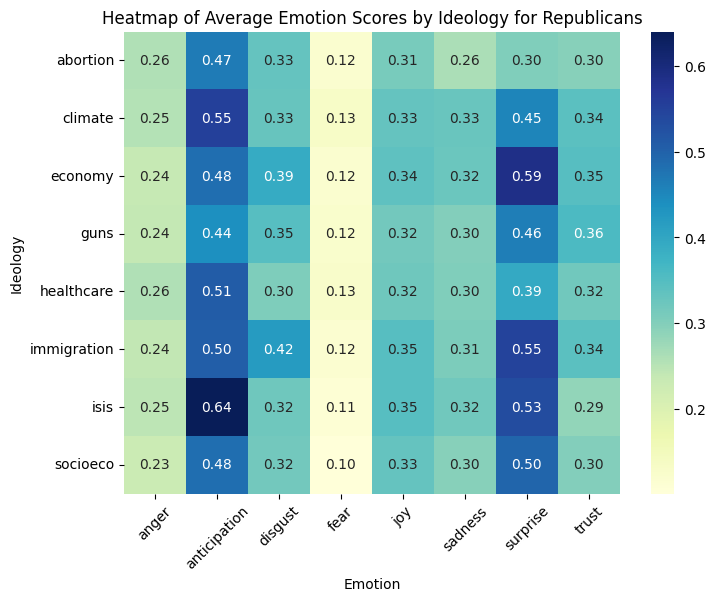

In [23]:
# Grouping the data by 'ideology' and then by 'Emotion' for the Republicans
republican_df_by_ideology = republican_df.groupby(['ideology', 'CommentEmotion'])['CommentEmotionScore'].mean().unstack(fill_value=0)

# Using seaborn to create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(republican_df_by_ideology, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Average Emotion Scores by Ideology for Republicans')
plt.xlabel('Emotion')
plt.ylabel('Ideology')
plt.xticks(rotation=45)
plt.show()

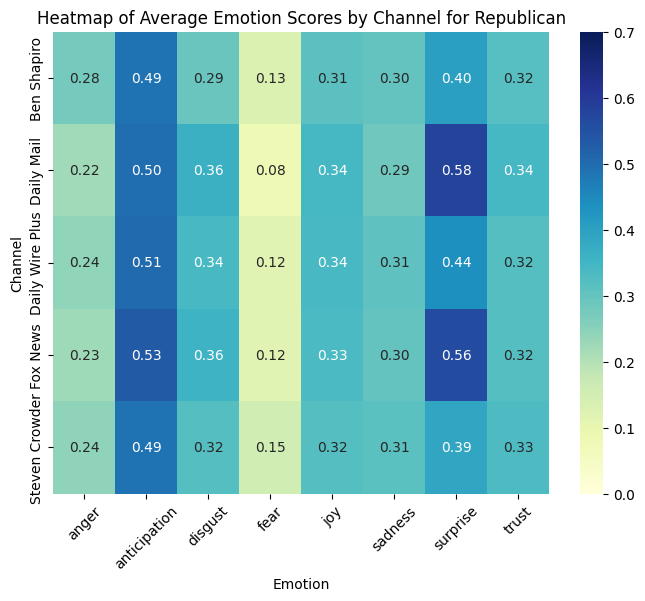

In [24]:
# Grouping the data by 'ideology' and then by 'Emotion' for the Democrats
republican_df_by_channel = republican_df.groupby(['channel', 'CommentEmotion'])['CommentEmotionScore'].mean().unstack(fill_value=0)

# Using seaborn to create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(republican_df_by_channel, annot=True, cmap="YlGnBu", fmt=".2f", vmin=0, vmax=0.7)
plt.title('Heatmap of Average Emotion Scores by Channel for Republican')
plt.xlabel('Emotion')
plt.ylabel('Channel')
plt.xticks(rotation=45)
plt.show()

Percentage Comment Emotion Distribution
anger: 0.074745
fear: 0.477513
sadness: 0.036326
anticipation: 0.058995
trust: 0.256555
joy: 0.047524
disgust: 0.016023
surprise: 0.032320


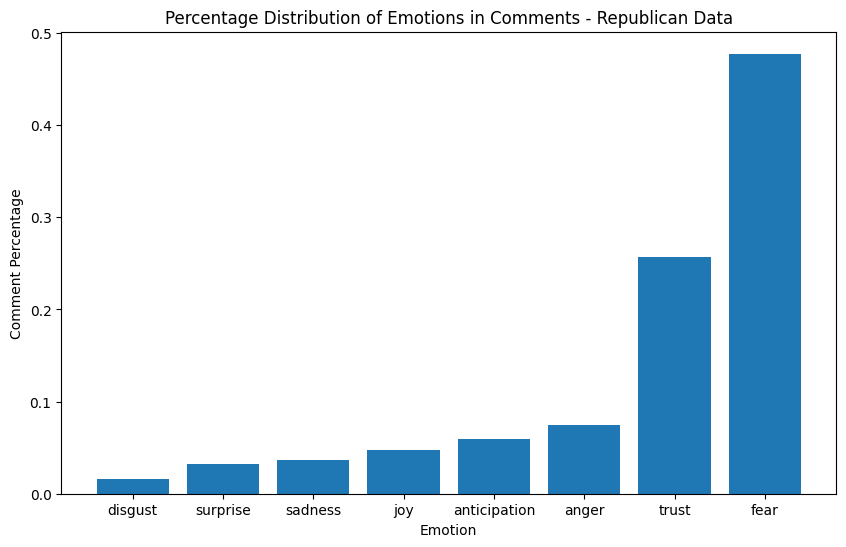

In [30]:
# Comment Emotion Distribution Analysis
print('Percentage Comment Emotion Distribution')
emo_per = {}

# Calculate and Output Emotion Percentage
for emo in republican_df['CommentEmotion'].unique():
    emo_per[emo] = len(republican_df[republican_df['CommentEmotion'] == emo])/len(republican_df)
    print('%s: %f' %(emo, emo_per[emo]))

# Order and Plot values
emo_per = dict(sorted(emo_per.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_per.keys(), emo_per.values())
plt.xlabel('Emotion')
plt.ylabel('Comment Percentage')
plt.title('Percentage Distribution of Emotions in Comments - Republican Data');

Percentage Comment Emotion Distribution
anger: 0.072105
fear: 0.453751
sadness: 0.046795
anticipation: 0.063547
trust: 0.268117
joy: 0.051347
disgust: 0.013565
surprise: 0.030772


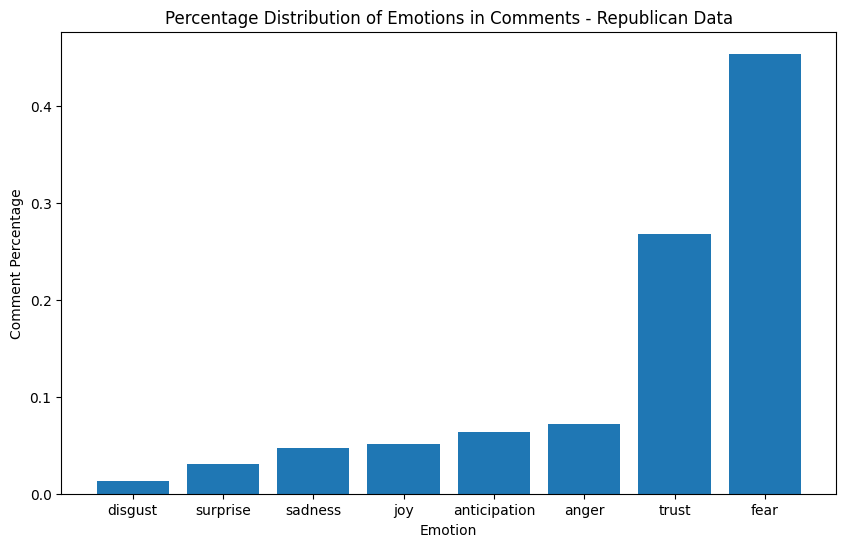

In [25]:
# Comment Emotion Distribution Analysis
print('Percentage Comment Emotion Distribution')
emo_per = {}

# Calculate and Output Emotion Percentage
for emo in republican_df['CommentEmotion'].unique():
    emo_per[emo] = len(republican_df.loc[demo_df['CommentEmotion'] == emo]) / len(republican_df)
    print('%s: %f' %(emo, emo_per[emo]))

# Order and Plot values
emo_per = dict(sorted(emo_per.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_per.keys(), emo_per.values())
plt.xlabel('Emotion')
plt.ylabel('Comment Percentage')
plt.title('Percentage Distribution of Emotions in Comments - Republican Data');

Percentage Title Emotion Distribution
fear: 0.680590
trust: 0.176904
anger: 0.051597
joy: 0.009828
surprise: 0.019656
anticipation: 0.029484
sadness: 0.024570
disgust: 0.007371


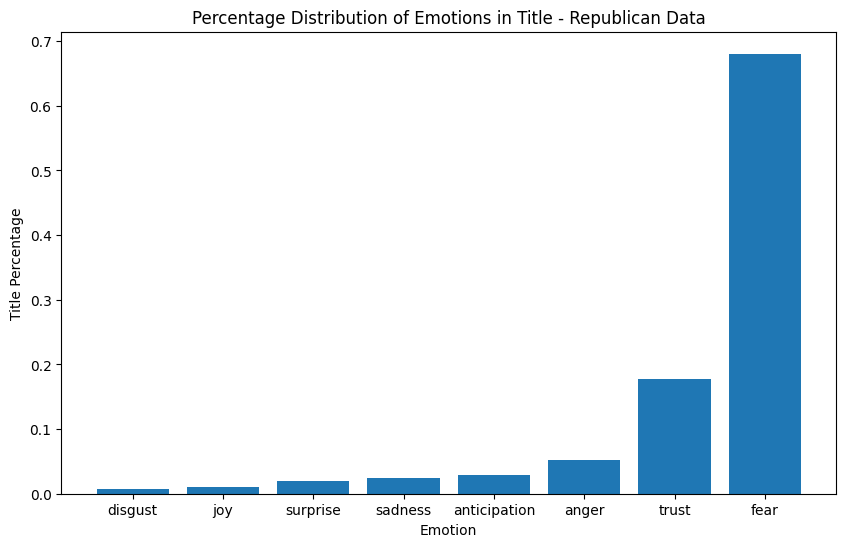

In [28]:
# Drop Duplicate Title Points
republican_df_title = republican_df.drop_duplicates(subset=['title'])

# Comment Emotion Distribution Analysis
print('Percentage Title Emotion Distribution')
emo_per = {}

# Calculate and Output Emotion Percentage
for emo in republican_df_title['TitleEmotion'].unique():
    emo_per[emo] = len(republican_df_title[republican_df_title['TitleEmotion'] == emo])/len(republican_df_title)
    print('%s: %f' %(emo, emo_per[emo]))

# Order and Plot values
emo_per = dict(sorted(emo_per.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_per.keys(), emo_per.values())
plt.xlabel('Emotion')
plt.ylabel('Title Percentage')
plt.title('Percentage Distribution of Emotions in Title - Republican Data');

Average Score per Emotion
fear: 0.213909
trust: 0.524557
anger: 0.268351
joy: 0.342262
surprise: 0.597917
anticipation: 0.467224
sadness: 0.433012
disgust: 0.583333


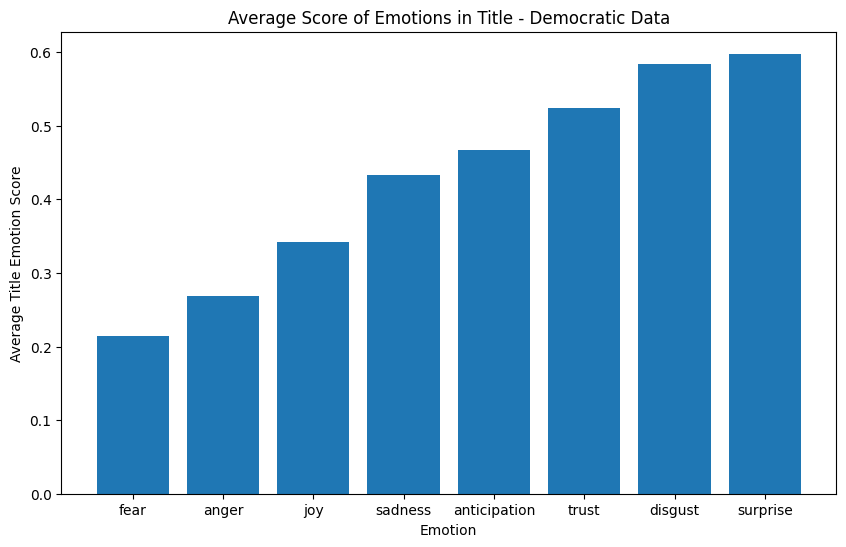

In [31]:
# Average Score per Emotion - Title

# Comment Emotion Distribution Analysis
print('Average Score per Emotion')
emo_score = {}

# Calculate and Output Emotion Percentage
for emo in republican_df_title['TitleEmotion'].unique():
    emo_score[emo] = republican_df_title[republican_df_title['TitleEmotion'] == emo]['TitleEmotionScore'].mean()
    print('%s: %f' %(emo, emo_score[emo]))

# Order and Plot values
emo_score = dict(sorted(emo_score.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_score.keys(), emo_score.values())
plt.xlabel('Emotion')
plt.ylabel('Average Title Emotion Score')
plt.title('Average Score of Emotions in Title - Democratic Data');


Average Score per Emotion
anger: 0.245308
fear: 0.119338
sadness: 0.301976
anticipation: 0.504654
trust: 0.324502
joy: 0.328527
disgust: 0.336825
surprise: 0.481200


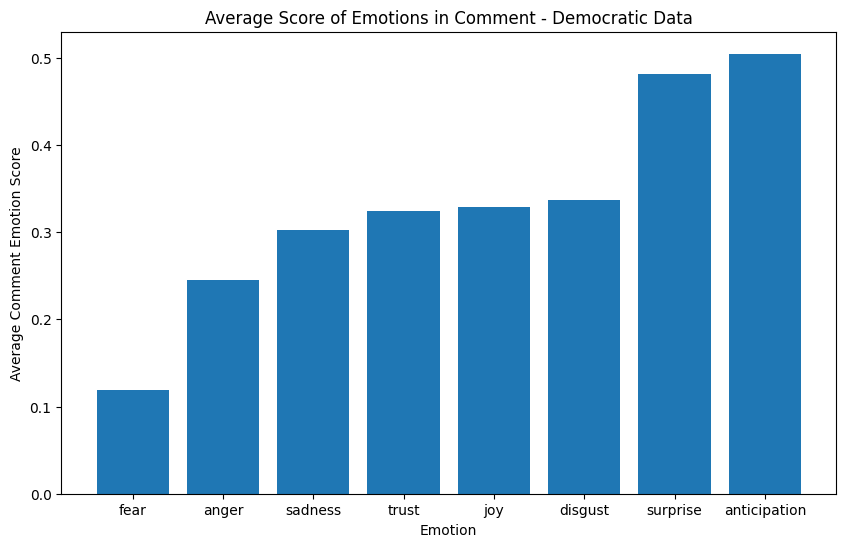

In [32]:
# Average Score per Emotion - Comment

# Comment Emotion Distribution Analysis
print('Average Score per Emotion')
emo_score = {}

# Calculate and Output Emotion Percentage
for emo in republican_df['CommentEmotion'].unique():
    emo_score[emo] = republican_df[republican_df['CommentEmotion'] == emo]['CommentEmotionScore'].mean()
    print('%s: %f' %(emo, emo_score[emo]))

# Order and Plot values
emo_score = dict(sorted(emo_score.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_score.keys(), emo_score.values())
plt.xlabel('Emotion')
plt.ylabel('Average Comment Emotion Score')
plt.title('Average Score of Emotions in Comment - Democratic Data');


Average Score per Emotion
anger: 0.235219
fear: 0.234072
sadness: 0.247017
anticipation: 0.242171
trust: 0.235347
joy: 0.235617
disgust: 0.238261
surprise: 0.238100


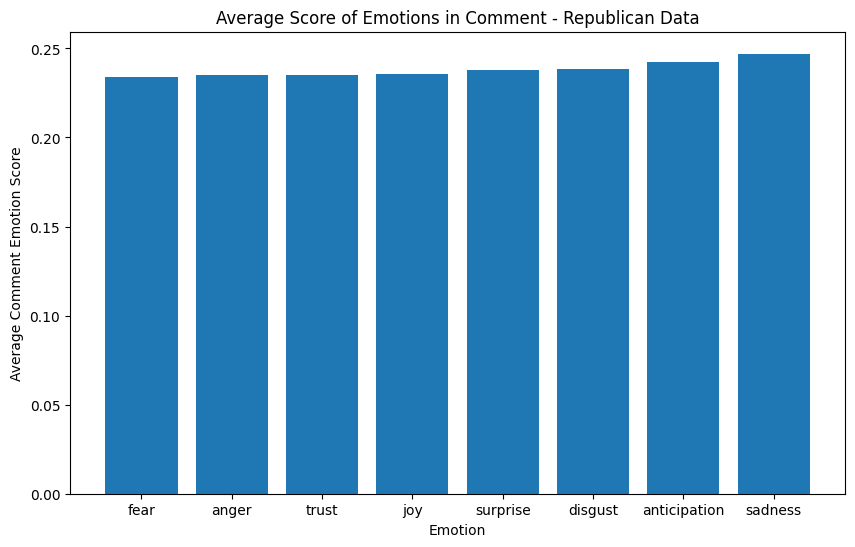

In [26]:
# Average Score per Emotion - Comment

# Comment Emotion Distribution Analysis
print('Average Score per Emotion')
emo_score = {}

# Calculate and Output Emotion Percentage
for emo in republican_df['CommentEmotion'].unique():
    emo_score[emo] = republican_df.loc[demo_df['CommentEmotion'] == emo, 'CommentEmotionScore'].mean()
    print('%s: %f' %(emo, emo_score[emo]))

# Order and Plot values
emo_score = dict(sorted(emo_score.items(), key = lambda x: x[1]))
plt.figure(figsize=(10,6))
plt.bar(emo_score.keys(), emo_score.values())
plt.xlabel('Emotion')
plt.ylabel('Average Comment Emotion Score')
plt.title('Average Score of Emotions in Comment - Republican Data');

## Analyze Data

Looking at the heatmaps, after correlating the emotions of comments across Democratic and Republican-focused channels, we can see a similar distribution of average scores across the eight different emotions. Anticipation and surprise were the leading emotions correlated with each channel across political parties.

The heatmaps correlating ideology and emotion within YouTube comments for each political party continue to show an observed similarity between the two parties. Again, the emotions of anticipation and surprise stand out in the heatmaps for both parties. However, within the two emotions, it can be observed that there are variances between the correlation of ideology and emotion. In Democratic channels, there was a strong correlation in comments between healthcare and anticipation. In contrast, for Republican channels, the strongest correlation for the emotion anticipation was ISIS (comments regarding terrorist theme).

When we observe the distribution of comments in the collected data, similarities between the two political parties can be seen. Fear and trust were the two emotions expressed the most across Democrat and Republican channel comments, with anger, anticipation, fear, joy, sadness, surprise, and disgust following in decreasing percentage.

Another difference observed in the comments between the two political parties was the average score of the emotions expressed in the comments. Comments under Republican channels shared similar scores across the whole range of emotions, with sadness being the lead emotion by score. For Democratic channels, average scores spread more, with anticipation being the lead emotion.